In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import math
import random
import pandas as pd

import scipy as sp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import dgl
import dgl.nn as dglnn

import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from collections import OrderedDict

from torch import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.utils.data._utils.collate import default_collate

from tqdm import tqdm
from dataset import ETTDataset, ETT_SPLIT

import warnings
warnings.simplefilter("ignore")

In [3]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dteakhperky (dteakhperky-higher-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

    generator = torch.Generator()
    generator.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [6]:
SEED = 0xBAD5EED
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Graph building functions

In [7]:
def compute_ess(x_series: np.ndarray, y_series: np.ndarray) -> float:
    """
    Calculates effective sample size for two time series (https://arxiv.org/pdf/2401.02387).
    :param x_series: X time series data
    :param y_series: Y time series data
    :returns: effective sample size
    """
    n = x_series.shape[0]
    x_dot = np.diff(x_series)
    y_dot = np.diff(y_series)
    ess = n * np.sqrt((np.var(x_dot) + np.var(y_dot)) / (2.0 * np.pi))
    return ess

def correlation_ess_estimation(x_series: np.ndarray, y_series: np.ndarray) -> float:
    """
    Estimates correlation between time series X and Y based on effective sample size (https://arxiv.org/pdf/2401.02387).
    :param x_series: X time series data
    :param y_series: Y time series data
    :returns: test statistic
    """
    n = x_series.shape[0]
    r, _ = sp.stats.pearsonr(x_series, y_series)
    ess = min(compute_ess(x_series, y_series), n)
    return np.sqrt(max(ess - 3, 0)) * np.atanh(r)

def ess_adjusted_pvalue_matrix(time_series: np.ndarray) -> np.ndarray:
    """
    Computes a matrix of ESS-adjusted p-values for pairwise correlations between time series components.
    The p-values test the null hypothesis that the true correlation is zero, accounting for autocorrelation.
    :param time_series: multivariate time series (n_samples, n_components)
    :returns: symmetric matrix of p-values of shape (n_components, n_components)
    """
    n_components = time_series.shape[1]
    pvalue_matrix = np.zeros((n_components, n_components))
    for i in range(n_components):
        for j in range(i + 1, n_components):
            test_stat = correlation_ess_estimation(time_series[:, i], time_series[:, j])
            p_value = 2 * sp.stats.norm.cdf(-np.abs(test_stat))
            pvalue_matrix[i, j] = p_value
            pvalue_matrix[j, i] = p_value

    return pvalue_matrix

In [8]:
def build_graph(time_series: np.ndarray, alpha: float = 0.05) -> dgl.graph:
    """
    Constructs graph of time series components based on alpha confidence level.
    :param time_series: multivariate time series (n_samples, n_components)
    :param alpha: confidence level
    :returns: constructed graph of components
    """
    n_components = time_series.shape[1]
    pvalues_matrix = ess_adjusted_pvalue_matrix(time_series)
    src_nodes, dst_nodes = np.where(pvalues_matrix <= alpha)
    return dgl.graph((src_nodes, dst_nodes), num_nodes=n_components)

# Dataset setup

In [9]:
ALPHA = 0.05
HORIZON_SIZE = 24
LOOKBACK_SIZE = 96

BATCH_SIZE = 64
NUM_WORKERS = 4

TOTAL_NUM_NODES = 7
TGT_COMP_IDX = TOTAL_NUM_NODES - 1

DATASET_NAME = "ETTh1.csv"

In [10]:
dataframe = pd.read_csv(Path(os.getcwd()) / "datasets" / DATASET_NAME)
full_val_ts = dataframe[dataframe.date.between(*ETT_SPLIT.val)].drop(columns="date").values
full_test_ts = dataframe[dataframe.date.between(*ETT_SPLIT.test)].drop(columns="date").values
full_train_ts = dataframe[dataframe.date.between(*ETT_SPLIT.train)].drop(columns="date").values

In [11]:
train_graph = build_graph(full_train_ts, alpha=ALPHA)
val_graph = build_graph(full_val_ts, alpha=ALPHA)
test_graph = build_graph(full_test_ts, alpha=ALPHA)

In [12]:
from dataset import get_datasets

train_ds, val_ds, test_ds = get_datasets(
    dataset_name=DATASET_NAME,
    lookback_size=LOOKBACK_SIZE,
    horizon_size=HORIZON_SIZE
)

In [13]:
import copy

class CustomGraphDataset(Dataset):
    def __init__(self, dataset: ETTDataset, global_graph: dgl.DGLGraph, alpha: float = 0.05):
        super().__init__()
        self.graphs: list[dgl.DGLGraph] = []
        self.targets: list[torch.Tensor] = []
        self.times: list[torch.Tensor] = []
        for idx in tqdm(range(len(dataset)), desc="Building graphs"):
            x_time, x_data, y_data = dataset[idx]
            graph = copy.deepcopy(global_graph)
            graph.ndata["h"] = x_data.T
            self.targets.append(y_data.T[TGT_COMP_IDX])
            self.times.append(x_time)
            self.graphs.append(graph)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx) -> tuple[dgl.DGLGraph, torch.Tensor]:
        return self.times[idx], self.graphs[idx], self.targets[idx]

In [14]:
def graph_collate_fn(batch):
    """
    Custom collate function for batching DGL graphs.
    :param graphs: batch of graphs and targets
    :returns: batched graph, batch of targets
    """
    batch_size = len(batch)
    times, graphs, targets = zip(*batch)
    horizon_size = targets[0].shape[0]
    lookback_size, n_features = times[0].shape
    times_tensor = torch.zeros((batch_size, lookback_size, n_features))
    targets_tensor = torch.zeros((batch_size, horizon_size))
    for idx in range(batch_size):
        targets_tensor[idx, :] = targets[idx]
        times_tensor[idx, :, :] = times[idx]

    return times_tensor, dgl.batch(graphs), targets_tensor

In [15]:
train_ds = CustomGraphDataset(train_ds, global_graph=train_graph, alpha=ALPHA)
val_ds = CustomGraphDataset(val_ds, global_graph=val_graph, alpha=ALPHA)
test_ds = CustomGraphDataset(test_ds, global_graph=test_graph, alpha=ALPHA)

Building graphs:   2%|▏         | 214/8641 [00:00<00:03, 2138.93it/s]

Building graphs: 100%|██████████| 2761/2761 [00:01<00:00, 2122.04it/s]


In [16]:
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    collate_fn=graph_collate_fn,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    collate_fn=graph_collate_fn,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    collate_fn=graph_collate_fn,
    drop_last=True
)

# Visualizations

In [17]:
def plot_graph(graph, title="Graph illustration"):
    plt.figure(figsize=(8, 5))
    plt.title(title + f" ({graph.num_edges()} edges)")
    g = graph.to_networkx().to_undirected()
    pos = nx.spring_layout(g)
    node_labels = {idx: label for idx, label in enumerate(["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"])}
    node_colors = ["red" if i == TGT_COMP_IDX else "skyblue" for i in range(graph.num_nodes())]
    nx.draw(g, pos, with_labels=True, labels=node_labels, node_color=node_colors, node_size=1000)

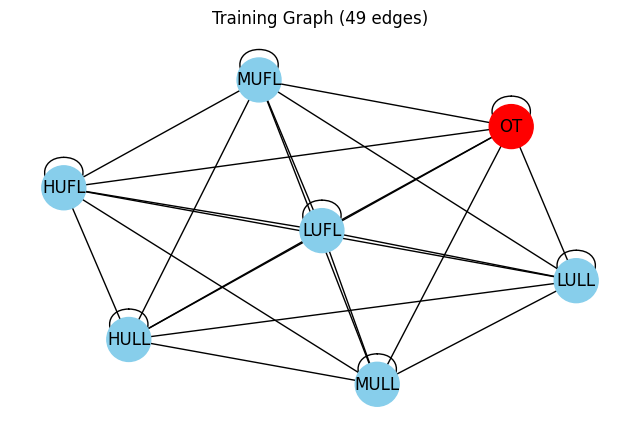

In [18]:
plot_graph(train_graph, "Training Graph")

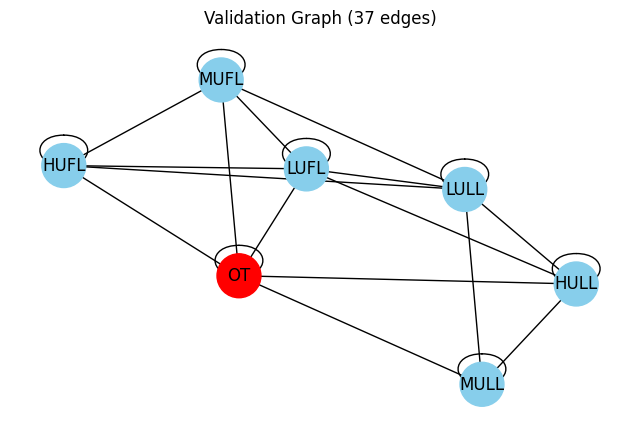

In [19]:
plot_graph(val_graph, "Validation Graph")

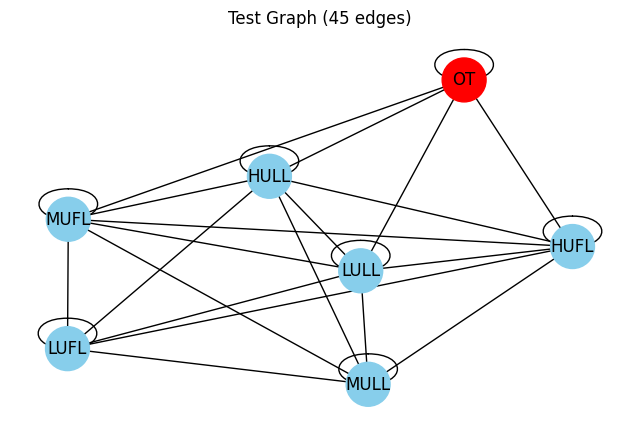

In [20]:
plot_graph(test_graph, "Test Graph")

# Model Setup

In [21]:
class GCNBlock(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, activation: nn.Module, residual: bool = True, dropout: float = 0):
        super().__init__()
        self.residual = residual
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.dropout = dropout

        self.norm = nn.LayerNorm(input_dim)
        self.gcn = dglnn.GraphConv(
            in_feats=self.input_dim,
            out_feats=self.hidden_dim,
            activation=self.activation()
        )
        self.dropout = nn.Dropout(self.dropout)
        if self.residual and self.input_dim != self.hidden_dim:
            self.skip = nn.Linear(self.input_dim, self.hidden_dim)
        if self.residual and self.input_dim == self.hidden_dim:
            self.skip = nn.Identity()

    def forward(self, graph, features):
        outputs = self.norm(features)
        outputs = self.gcn(graph, outputs)
        outputs = self.dropout(outputs)
        if self.residual:
            outputs = outputs + self.skip(features)

        return outputs

In [22]:
class GCNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, activation: nn.Module, residual: bool = True, dropout: float = 0):
        super().__init__()
        self.residual = residual
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.activation = activation
        self.dropout = dropout
        
        self.blocks = nn.ModuleList()
        for i in range(num_layers):
            self.blocks.append(GCNBlock(
                input_dim=self.input_dim if i == 0 else self.hidden_dim,
                hidden_dim=self.hidden_dim,
                activation=self.activation,
                residual=self.residual,
                dropout=self.dropout
            ))
    
    def forward(self, graph, features):
        outputs = features
        for block in self.blocks:
            outputs = block(graph, outputs)
        
        return outputs

In [23]:
class Encoding(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        weight = torch.zeros(self.input_dim, self.output_dim, requires_grad=False).float()
        pos_enc = torch.arange(0, self.input_dim).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.output_dim, 2).float() * -(math.log(10000.0) / self.output_dim))

        weight[:, 0::2] = torch.sin(pos_enc * div_term)
        weight[:, 1::2] = torch.cos(pos_enc * div_term)

        self.embeddings = nn.Embedding(self.input_dim, self.output_dim)
        self.embeddings.weight = nn.Parameter(weight, requires_grad=False) # not learnable

    def forward(self, x):
        return self.embeddings(x).detach()

class TimeEncoding(nn.Module):
    def __init__(self, output_dim, learnable: bool = False):
        super().__init__()
        self.output_dim = output_dim
        self.learnable = learnable

        Embedding = Encoding if self.learnable else nn.Embedding
        self.month_embed = Embedding(13, self.output_dim)
        self.weekday_embed = Embedding(7, self.output_dim)
        self.day_embed = Embedding(32, self.output_dim)
        self.hour_embed = Embedding(24, self.output_dim)
        self.minute_embed = Embedding(4, self.output_dim)
    
    def forward(self, x):
        x = x.long()
        month = self.month_embed(x[:, 0, 0])
        weekday = self.weekday_embed(x[:, 0, 1])
        day = self.day_embed(x[:, 0, 2])
        hour = self.hour_embed(x[:, 0, 3])
        minute = self.minute_embed(x[:, 0, 4])
        return month + weekday + day + hour + minute

In [24]:
class GraphTSModel(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        horizon_size: int,
        num_layers: int,
        activation: nn.Module,
        residual: bool = True,
        dropout: float = 0,
        time_learnable: bool = False,
    ):
        super().__init__()
        self.residual = residual
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.activation = activation
        self.dropout = dropout
        self.horizon_size = horizon_size
        self.time_learnable = time_learnable
        
        self.time_emb = TimeEncoding(
            output_dim=self.input_dim,
            learnable=self.time_learnable
        )
        
        self.backbone = GCNModel(
            input_dim=self.input_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            activation=self.activation,
            residual=self.residual,
            dropout=self.dropout
        )
        self.head = nn.Linear(self.hidden_dim, self.horizon_size)
    
    def forward(self, graph, features, time_features):
        time = self.time_emb(time_features)
        time = time.unsqueeze(1).repeat(1, TOTAL_NUM_NODES, 1)
        x = features + time.reshape(-1, features.shape[-1])
        outputs = self.backbone(graph, x)
        tgt_emb = outputs[TGT_COMP_IDX::TOTAL_NUM_NODES] # extract OT's embeddings
        outputs = self.head(tgt_emb)
        return outputs

In [25]:
def test_model_correctness():
    times, g, _ = next(iter(test_loader))
    model = GraphTSModel(
        input_dim=LOOKBACK_SIZE,
        hidden_dim=256,
        horizon_size=HORIZON_SIZE,
        num_layers=3,
        activation=nn.ReLU,
    )
    assert model(g, g.ndata["h"], times).shape[0] == BATCH_SIZE, f"{model(g, g.ndata['h'], times).shape}"
    assert model(g, g.ndata["h"], times).shape[1] == HORIZON_SIZE, f"{model(g, g.ndata['h'], times).shape}"
    print("Seems to be correct!")

In [26]:
test_model_correctness()

Seems to be correct!


# Training setup

In [27]:
def train_step(train_loader, model, optimizer, loss_fn):
    model.train()
    loss_acum = 0
    samples_cnt = 0
    scaler = GradScaler()
    for times, graph, targets in tqdm(train_loader):
        graph = graph.to(device)
        times = times.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            outputs = model(graph, graph.ndata["h"], times)
            loss = loss_fn(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loss_acum += targets.shape[0] * loss.item()
        samples_cnt += targets.shape[0]
        wandb.log({"train_mse": loss.item()})
    
    return {"loss": loss_acum / samples_cnt}

In [28]:
@torch.inference_mode()
def evaluation_step(val_loader, model, loss_fn):
    model.eval()
    loss_acum = 0
    samples_cnt = 0
    for times, graph, targets in tqdm(val_loader):
        graph = graph.to(device)
        times = times.to(device)
        targets = targets.to(device)
        outputs = model(graph, graph.ndata["h"], times)
        loss = loss_fn(outputs, targets)
        loss_acum += targets.shape[0] * loss.item()
        samples_cnt += targets.shape[0]
        wandb.log({"val_mse": loss.item()})

    return {"loss": loss_acum / samples_cnt}

In [29]:
def train(num_epochs, model, optimizer, scheduler, loss_fn, train_loader, val_loader):
    model = model.to(device)
    for epoch in range(1, num_epochs + 1):
        print(f"TRAINING EPOCH={epoch}")

        train_output = train_step(
            train_loader=train_loader,
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn
        )
        val_output = evaluation_step(
            val_loader=val_loader,
            model=model,
            loss_fn=loss_fn
        )
        
        if scheduler is not None:
            scheduler.step()

        print(f"Train Loss: {train_output['loss']}")
        print(f"Validation Loss: {val_output['loss']}")
    
    return None

# Training

In [30]:
g  = next(iter(train_loader))[1]
INPUT_DIM = g.ndata["h"].shape[-1]

In [31]:
HIDDEN_DIM = 512
NUM_LAYERS = 4
RESIDUAL = True
ACTIVATION = nn.ReLU
LEARNABLE = True
DROPOUT = 0.10

model = GraphTSModel(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    horizon_size=HORIZON_SIZE,
    num_layers=NUM_LAYERS,
    activation=ACTIVATION,
    residual=RESIDUAL,
    time_learnable=LEARNABLE,
    dropout=DROPOUT
)

f"Parameters Number: {sum(p.numel() for p in model.parameters()) / 1e6:.3f}M"

'Parameters Number: 0.911M'

In [32]:
WEIGHT_DECAY = 0.0
LEARNING_RATE = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=1e-2, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = None
loss_fn = nn.MSELoss()

In [33]:
NUM_EPOCHS = 20

wandb.init(
    project="gnn-ts",
    name="test",
    config={
        "graph_strategy": "local",
        "alpha": ALPHA,
        "model": "GCN",
        "lookback_size": LOOKBACK_SIZE,
        "horizon_size": HORIZON_SIZE,
        "time_usage": "None",
        "input_dim": INPUT_DIM,
        "hidden_dim": HIDDEN_DIM,
        "num_layers": NUM_LAYERS,
        "activation": "ReLU",
        "residual": RESIDUAL,
        "batch_size": BATCH_SIZE,
        "num_epochs": NUM_EPOCHS,
        "weight_decay": WEIGHT_DECAY,
        "learning_rate": LEARNING_RATE,
        "scheduler": "None",
        "optimizer": "AdamW"
    }
)

In [34]:
train(
    num_epochs=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
)

TRAINING EPOCH=1


100%|██████████| 44/44 [00:00<00:00, 47.84it/s]


Train Loss: 38.14155596980342
Validation Loss: 8.980125681920486
TRAINING EPOCH=2


100%|██████████| 44/44 [00:00<00:00, 46.15it/s]


Train Loss: 9.92990952597724
Validation Loss: 5.3289247710596435
TRAINING EPOCH=3


100%|██████████| 44/44 [00:00<00:00, 45.34it/s]


Train Loss: 8.215156120724147
Validation Loss: 4.541574474085461
TRAINING EPOCH=4


100%|██████████| 44/44 [00:00<00:00, 52.60it/s]


Train Loss: 7.483035592679625
Validation Loss: 4.400979896838015
TRAINING EPOCH=5


100%|██████████| 44/44 [00:00<00:00, 54.02it/s]


Train Loss: 7.051743606284813
Validation Loss: 4.659810108217326
TRAINING EPOCH=6


100%|██████████| 44/44 [00:01<00:00, 39.33it/s]


Train Loss: 6.823473227465594
Validation Loss: 5.158391051671722
TRAINING EPOCH=7


100%|██████████| 44/44 [00:01<00:00, 42.42it/s]


Train Loss: 6.668268758279306
Validation Loss: 4.021224306388334
TRAINING EPOCH=8


100%|██████████| 44/44 [00:00<00:00, 51.88it/s]


Train Loss: 6.511575946101436
Validation Loss: 4.3984439969062805
TRAINING EPOCH=9


100%|██████████| 44/44 [00:00<00:00, 51.71it/s]


Train Loss: 6.398009367342349
Validation Loss: 4.321078931743449
TRAINING EPOCH=10


100%|██████████| 44/44 [00:00<00:00, 56.23it/s]


Train Loss: 6.349618964725071
Validation Loss: 4.27909137850458
TRAINING EPOCH=11


100%|██████████| 44/44 [00:00<00:00, 58.71it/s]


Train Loss: 6.171474947752776
Validation Loss: 4.310308113694191
TRAINING EPOCH=12


100%|██████████| 44/44 [00:00<00:00, 45.45it/s]


Train Loss: 6.151403494234438
Validation Loss: 4.209737275134433
TRAINING EPOCH=13


100%|██████████| 44/44 [00:00<00:00, 45.39it/s]


Train Loss: 6.148676886381926
Validation Loss: 4.401515536687591
TRAINING EPOCH=14


100%|██████████| 44/44 [00:00<00:00, 54.77it/s]


Train Loss: 6.13674949893245
Validation Loss: 4.116218095475977
TRAINING EPOCH=15


100%|██████████| 44/44 [00:00<00:00, 55.44it/s]


Train Loss: 6.120445760091146
Validation Loss: 4.244402958588167
TRAINING EPOCH=16


100%|██████████| 44/44 [00:00<00:00, 47.79it/s]


Train Loss: 6.112668461269802
Validation Loss: 4.149178163571791
TRAINING EPOCH=17


100%|██████████| 44/44 [00:00<00:00, 59.28it/s]


Train Loss: 6.09897034962972
Validation Loss: 4.270514016801661
TRAINING EPOCH=18


100%|██████████| 44/44 [00:00<00:00, 56.46it/s]


Train Loss: 6.087549795927825
Validation Loss: 4.4119036536325105
TRAINING EPOCH=19


100%|██████████| 44/44 [00:00<00:00, 52.77it/s]


Train Loss: 6.083304521772597
Validation Loss: 4.189384655518965
TRAINING EPOCH=20


100%|██████████| 44/44 [00:00<00:00, 55.33it/s]

Train Loss: 6.075244320763482
Validation Loss: 4.324708518656817


In [35]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


train_mse,▇█▄▆▅▂▄▃▃▃▂▂▄▃▅▂▂▂▂▂▂▂▁▂▁▁▄▆▂▃▁▂▃▁▃▂▁▃▂▁
val_mse,▃▃▃▂▁▃▅▂▂▃▃▃▂▃▂▄▂▁▁▂▁█▂▂▂▁▂▃▂▄▄█▁▁▂█▂▃▁█
train_mse,5.78677
val_mse,0.67496


# Inference

In [36]:
@torch.inference_mode()
def inference(model, test_loader):
    model.eval()
    loss_acum = 0
    samples_cnt = 0
    for times, graph, targets in tqdm(test_loader):
        graph = graph.to(device)
        times = times.to(device)
        targets = targets.to(device)
        outputs = model(graph, graph.ndata["h"], times)
        loss = F.mse_loss(outputs, targets)
        loss_acum += targets.shape[0] * loss
        samples_cnt += targets.shape[0]
    
    return loss_acum / samples_cnt

In [37]:
inference(model, test_loader)

  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:00<00:00, 46.04it/s]


tensor(4.4479, device='cuda:0')

In [38]:
inference(model, val_loader)

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [00:00<00:00, 53.40it/s]


tensor(4.3247, device='cuda:0')

In [39]:
inference(model, train_loader)

  0%|          | 0/135 [00:00<?, ?it/s]

100%|██████████| 135/135 [00:02<00:00, 62.75it/s]


tensor(6.0257, device='cuda:0')